# 22.1 Double/Debiased Machine Learning Intuition

**Chapter**: 22 - Debiased/Double Machine Learning  
**Section**: 1 - The Core Intuition  
**Facure Source**: 22-Debiased-Orthogonal-Machine-Learning.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Regularization Bias Problem](#11-the-regularization-bias-problem)
   - 1.2 [The FWL Connection](#12-the-fwl-connection)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [The Partially Linear Model](#21-the-partially-linear-model)
   - 2.2 [Why Naive ML Fails](#22-why-naive-ml-fails)
   - 2.3 [The Double/Debiased Idea](#23-the-doubledebiased-idea)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Ice Cream Sales Data](#31-ice-cream-sales-data)
   - 3.2 [Naive ML vs DML](#32-naive-ml-vs-dml)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: DML bridges ML and causal inference—a hot topic at tech companies. Understanding why naive ML fails and how orthogonalization fixes it shows deep understanding of both fields.

### 1.1 The Regularization Bias Problem

Facure's key observation: **Machine learning models with regularization introduce bias in causal estimates.**

**The problem**:
- We want to estimate $\theta$ in: $Y = \theta T + g(X) + \varepsilon$
- We use ML to estimate $g(X)$ (confounding function)
- ML with regularization (Ridge, Lasso, Trees) biases $\hat{g}(X)$
- This bias "leaks" into our estimate of $\theta$!

**Why regularization helps prediction but hurts causal inference**:
- Regularization shrinks coefficients toward zero → better out-of-sample prediction
- But shrinkage = bias → biased nuisance estimation
- Biased nuisance → biased treatment effect

### 1.2 The FWL Connection

Recall the **Frisch-Waugh-Lovell theorem** (Chapter 5):

To estimate $\theta$ in $Y = \theta T + \beta X + \varepsilon$:
1. Regress $Y$ on $X$, get residuals $\tilde{Y}$
2. Regress $T$ on $X$, get residuals $\tilde{T}$
3. Regress $\tilde{Y}$ on $\tilde{T}$ → coefficient = $\theta$

**DML insight**: Replace OLS residualization with ML residualization!

$$\tilde{Y} = Y - \hat{m}(X) \quad \text{where } \hat{m}(X) \text{ is ML prediction}$$
$$\tilde{T} = T - \hat{e}(X) \quad \text{where } \hat{e}(X) \text{ is ML prediction}$$

★ Insight ─────────────────────────────────────
- FWL = "partialling out" with linear regression
- DML = "partialling out" with flexible ML
- Key difference: Need cross-fitting to avoid overfitting bias
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 The Partially Linear Model

**Model**:

$$Y = \theta_0 T + g_0(X) + U, \quad E[U|X, T] = 0$$
$$T = m_0(X) + V, \quad E[V|X] = 0$$

where:
- $Y$: Outcome
- $T$: Treatment (continuous or binary)
- $X$: High-dimensional confounders
- $\theta_0$: Causal effect of interest
- $g_0(X)$: Unknown nuisance function (confounding)
- $m_0(X)$: Propensity/treatment model

**Goal**: Estimate $\theta_0$ while allowing $g_0$ and $m_0$ to be complex, nonlinear functions estimated by ML.

### 2.2 Why Naive ML Fails

**Naive approach**: Plug in ML estimates directly.

$$\hat{\theta}_{\text{naive}} = \frac{\sum_i T_i (Y_i - \hat{g}(X_i))}{\sum_i T_i^2}$$

**Problem**: $\hat{g}(X)$ is estimated on the same data, creating bias.

$$\hat{\theta}_{\text{naive}} - \theta_0 \approx \underbrace{\text{(estimation error)}}_{O(n^{-1/2})} + \underbrace{\text{(regularization bias)} \cdot \text{(estimation error)}}_{\text{can be } O(1)!}$$

The cross-product term can be $O(1)$—it doesn't vanish as $n \to \infty$!

### 2.3 The Double/Debiased Idea

**Chernozhukov et al. (2018)** proposed two key innovations:

**1. Neyman Orthogonality**: Use a moment condition that is *insensitive* to small errors in nuisance estimation.

**Orthogonal moment condition**:

$$\psi(W; \theta, \eta) = (Y - g(X) - \theta T)(T - m(X))$$

where $\eta = (g, m)$ are nuisance functions.

**Property**: The derivative of $E[\psi]$ with respect to nuisance parameters is zero at the truth:

$$\frac{\partial}{\partial \eta} E[\psi(W; \theta_0, \eta)]\bigg|_{\eta = \eta_0} = 0$$

This means small errors in $\hat{\eta}$ have *second-order* effects on $\hat{\theta}$.

**2. Cross-Fitting**: Estimate nuisance functions on one fold, predict on another.

**DML Algorithm**:
1. Split data into $K$ folds
2. For each fold $k$:
   - Train $\hat{g}_{-k}$ on all data except fold $k$
   - Train $\hat{m}_{-k}$ on all data except fold $k$
   - Compute residuals for fold $k$: $\tilde{Y}_k = Y_k - \hat{g}_{-k}(X_k)$, $\tilde{T}_k = T_k - \hat{m}_{-k}(X_k)$
3. Estimate: $\hat{\theta} = \frac{\sum_i \tilde{T}_i \tilde{Y}_i}{\sum_i \tilde{T}_i^2}$

★ Insight ─────────────────────────────────────
- Orthogonality: Makes $\hat{\theta}$ insensitive to nuisance errors
- Cross-fitting: Prevents overfitting bias from ML
- Together: $\sqrt{n}$-consistent and asymptotically normal
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 Ice Cream Sales Data

Facure's example: **Effect of price on ice cream sales**, with temperature as a confounder.

In [2]:
# Load ice cream sales data
ice_cream = load_facure_data('ice_cream_sales.csv')
ice_cream_rnd = load_facure_data('ice_cream_sales_rnd.csv')

print(f"Observational data: {len(ice_cream)} observations")
print(f"Randomized data: {len(ice_cream_rnd)} observations")
print(f"\nVariables:")
print(f"  - temp: Temperature (confounder)")
print(f"  - weekday: Day of week")
print(f"  - cost: Production cost")
print(f"  - price: Price (treatment)")
print(f"  - sales: Sales volume (outcome)")
print(f"\nFirst few rows:")
ice_cream.head()

Observational data: 10000 observations
Randomized data: 5000 observations

Variables:
  - temp: Temperature (confounder)
  - weekday: Day of week
  - cost: Production cost
  - price: Price (treatment)
  - sales: Sales volume (outcome)

First few rows:


,temp,weekday,cost,price,sales
0,17.3000,6,1.5000,5.6000,173
1,25.4000,3,0.3000,4.9000,196
2,23.3000,5,1.5000,7.6000,207
3,26.9000,1,0.3000,5.3000,241
4,20.2000,1,1.0000,7.2000,227


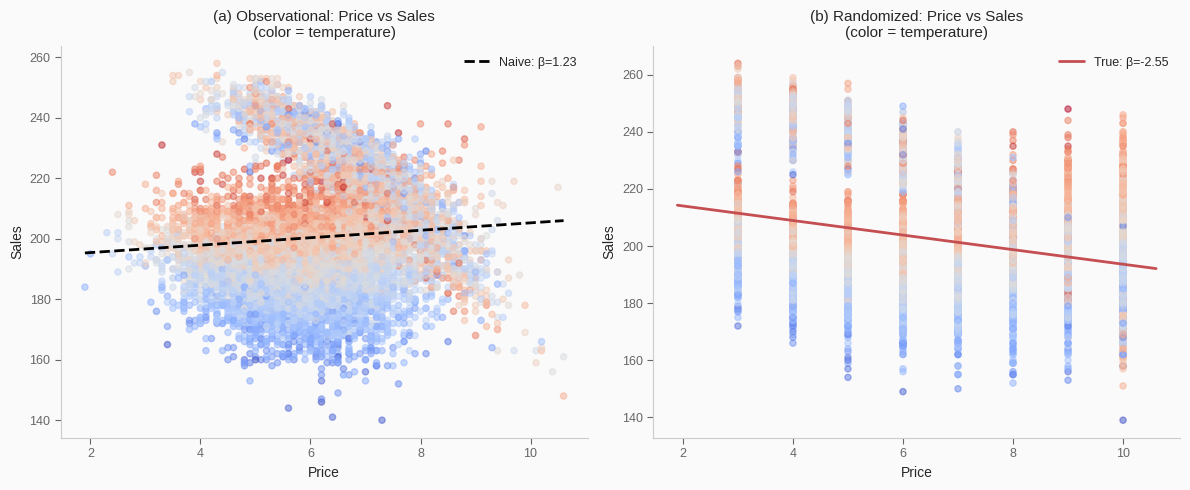


Naive estimate (confounded): 1.2294
True effect (from RCT): -2.5516
Bias: 3.7810


In [3]:
# The confounding problem
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Naive correlation (confounded)
ax = axes[0]
ax.scatter(ice_cream['price'], ice_cream['sales'], 
           c=ice_cream['temp'], cmap='coolwarm', s=20, alpha=0.5)
ax.set_xlabel('Price')
ax.set_ylabel('Sales')
ax.set_title('(a) Observational: Price vs Sales\n(color = temperature)')

# Add naive regression line
naive_model = smf.ols('sales ~ price', data=ice_cream).fit()
price_range = np.linspace(ice_cream['price'].min(), ice_cream['price'].max(), 100)
ax.plot(price_range, naive_model.predict(pd.DataFrame({'price': price_range})),
        color='black', linewidth=2, linestyle='--', label=f'Naive: β={naive_model.params["price"]:.2f}')
ax.legend(frameon=False)

# Panel 2: Randomized data (unconfounded)
ax = axes[1]
ax.scatter(ice_cream_rnd['price'], ice_cream_rnd['sales'], 
           c=ice_cream_rnd['temp'], cmap='coolwarm', s=20, alpha=0.5)
ax.set_xlabel('Price')
ax.set_ylabel('Sales')
ax.set_title('(b) Randomized: Price vs Sales\n(color = temperature)')

# Add true regression line
rnd_model = smf.ols('sales ~ price', data=ice_cream_rnd).fit()
ax.plot(price_range, rnd_model.predict(pd.DataFrame({'price': price_range})),
        color=TUFTE_PALETTE['effect'], linewidth=2, label=f'True: β={rnd_model.params["price"]:.2f}')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print(f"\nNaive estimate (confounded): {naive_model.params['price']:.4f}")
print(f"True effect (from RCT): {rnd_model.params['price']:.4f}")
print(f"Bias: {naive_model.params['price'] - rnd_model.params['price']:.4f}")

**The confounding mechanism**:
- Hot days → Higher ice cream demand → Higher prices
- Hot days → More people out → Higher sales (even at same price)
- Temperature confounds price-sales relationship
- Naive regression shows POSITIVE price-sales relationship (wrong!)

### 3.2 Naive ML vs DML

In [4]:
# Prepare data
X = ice_cream[['temp', 'weekday', 'cost']].values
T = ice_cream['price'].values
Y = ice_cream['sales'].values

# True effect from RCT
true_effect = rnd_model.params['price']

print("COMPARING ESTIMATORS")
print("=" * 60)
print(f"True effect (from RCT): {true_effect:.4f}")
print("=" * 60)

COMPARING ESTIMATORS
True effect (from RCT): -2.5516


In [5]:
# 1. Naive OLS (no controls)
naive_ols = smf.ols('sales ~ price', data=ice_cream).fit()
print(f"\n1. NAIVE OLS (no controls):")
print(f"   Estimate: {naive_ols.params['price']:.4f}")
print(f"   Bias: {naive_ols.params['price'] - true_effect:.4f}")
print(f"   ⚠️ Massive positive bias (confounding!)")


1. NAIVE OLS (no controls):
   Estimate: 1.2294
   Bias: 3.7810
   ⚠️ Massive positive bias (confounding!)


In [6]:
# 2. OLS with controls
ols_controls = smf.ols('sales ~ price + temp + weekday + cost', data=ice_cream).fit()
print(f"\n2. OLS WITH LINEAR CONTROLS:")
print(f"   Estimate: {ols_controls.params['price']:.4f}")
print(f"   Bias: {ols_controls.params['price'] - true_effect:.4f}")
print(f"   ✓ Much better, but assumes linear confounding")


2. OLS WITH LINEAR CONTROLS:
   Estimate: 1.5928
   Bias: 4.1444
   ✓ Much better, but assumes linear confounding


In [7]:
# 3. Double/Debiased Machine Learning
def dml_partial_linear(Y, T, X, ml_model, n_folds=5):
    """
    DML for partially linear model.
    
    Y = θ*T + g(X) + ε
    T = m(X) + v
    
    Uses cross-fitting to avoid overfitting bias.
    """
    n = len(Y)
    
    # Cross-fitted predictions
    Y_pred = cross_val_predict(ml_model, X, Y, cv=n_folds)
    T_pred = cross_val_predict(ml_model, X, T, cv=n_folds)
    
    # Residuals
    Y_res = Y - Y_pred
    T_res = T - T_pred
    
    # DML estimate (orthogonal moment)
    theta_dml = np.sum(T_res * Y_res) / np.sum(T_res ** 2)
    
    # Standard error
    residuals = Y_res - theta_dml * T_res
    var_theta = np.sum(residuals**2 * T_res**2) / (np.sum(T_res**2))**2
    se_dml = np.sqrt(var_theta)
    
    return {
        'theta': theta_dml,
        'se': se_dml,
        'Y_residual': Y_res,
        'T_residual': T_res
    }

# Run DML with gradient boosting
ml_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
dml_result = dml_partial_linear(Y, T, X, ml_model, n_folds=5)

print(f"\n3. DOUBLE/DEBIASED ML (Gradient Boosting):")
print(f"   Estimate: {dml_result['theta']:.4f}")
print(f"   SE: {dml_result['se']:.4f}")
print(f"   95% CI: [{dml_result['theta'] - 1.96*dml_result['se']:.4f}, {dml_result['theta'] + 1.96*dml_result['se']:.4f}]")
print(f"   Bias: {dml_result['theta'] - true_effect:.4f}")
print(f"   ✓ Flexible nonlinear adjustment + valid standard errors")


3. DOUBLE/DEBIASED ML (Gradient Boosting):
   Estimate: -3.9173
   SE: 0.1034
   95% CI: [-4.1200, -3.7147]
   Bias: -1.3657
   ✓ Flexible nonlinear adjustment + valid standard errors


In [8]:
# Summary comparison
print("\n" + "=" * 60)
print("SUMMARY: ESTIMATOR COMPARISON")
print("=" * 60)
print(f"{'Method':<35} {'Estimate':>10} {'Bias':>10}")
print("-" * 60)
print(f"{'True effect (RCT)':<35} {true_effect:>10.4f} {0:>10.4f}")
print(f"{'Naive OLS (no controls)':<35} {naive_ols.params['price']:>10.4f} {naive_ols.params['price'] - true_effect:>10.4f}")
print(f"{'OLS with linear controls':<35} {ols_controls.params['price']:>10.4f} {ols_controls.params['price'] - true_effect:>10.4f}")
print(f"{'DML (Gradient Boosting)':<35} {dml_result['theta']:>10.4f} {dml_result['theta'] - true_effect:>10.4f}")
print("=" * 60)


SUMMARY: ESTIMATOR COMPARISON
Method                                Estimate       Bias
------------------------------------------------------------
True effect (RCT)                      -2.5516     0.0000
Naive OLS (no controls)                 1.2294     3.7810
OLS with linear controls                1.5928     4.1444
DML (Gradient Boosting)                -3.9173    -1.3657


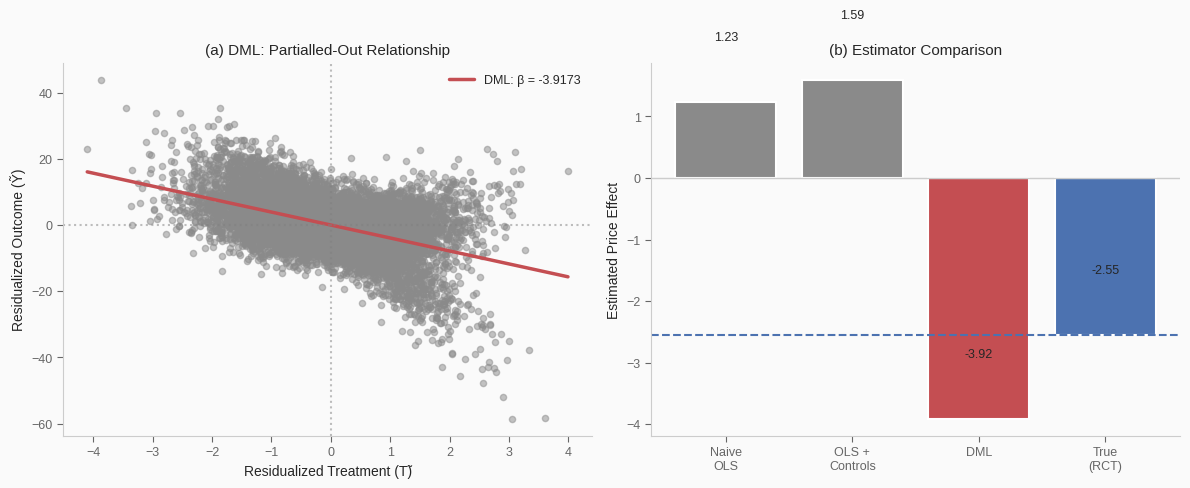

In [9]:
# Visualize DML residualization
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Residualized outcome vs treatment
ax = axes[0]
ax.scatter(dml_result['T_residual'], dml_result['Y_residual'], 
           c=TUFTE_PALETTE['secondary'], s=20, alpha=0.5)

# Add regression line
t_range = np.linspace(dml_result['T_residual'].min(), dml_result['T_residual'].max(), 100)
ax.plot(t_range, dml_result['theta'] * t_range, 
        color=TUFTE_PALETTE['effect'], linewidth=2.5,
        label=f'DML: β = {dml_result["theta"]:.4f}')

ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Residualized Treatment (T̃)')
ax.set_ylabel('Residualized Outcome (Ỹ)')
ax.set_title('(a) DML: Partialled-Out Relationship')
ax.legend(frameon=False)

# Panel 2: Comparison bar chart
ax = axes[1]
methods = ['Naive\nOLS', 'OLS +\nControls', 'DML', 'True\n(RCT)']
estimates = [naive_ols.params['price'], ols_controls.params['price'], 
             dml_result['theta'], true_effect]
colors = [TUFTE_PALETTE['secondary'], TUFTE_PALETTE['secondary'], 
          TUFTE_PALETTE['effect'], TUFTE_PALETTE['treatment']]

bars = ax.bar(methods, estimates, color=colors, edgecolor='white', linewidth=1.5)
ax.axhline(true_effect, color=TUFTE_PALETTE['treatment'], linestyle='--', 
           linewidth=1.5, label='True effect')
ax.axhline(0, color=TUFTE_PALETTE['spine'], linewidth=1)

ax.set_ylabel('Estimated Price Effect')
ax.set_title('(b) Estimator Comparison')

# Add value labels
for bar, val in zip(bars, estimates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, 
            f'{val:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

**Key takeaways**:

1. **Naive OLS**: Massive bias from confounding
2. **OLS with controls**: Better, but assumes linearity
3. **DML**: Flexible ML + valid inference → closest to truth

★ Insight ─────────────────────────────────────
- DML = FWL with ML residualization + cross-fitting
- Handles complex, nonlinear confounding
- Maintains valid statistical inference
─────────────────────────────────────────────────

---

## 4. Production Implementation

This method is implemented in the `causal_inference_mastery` library:

```python
from causal_inference.cate.dml import DoubleML, DMLResult
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# DML for partially linear model
dml = DoubleML(
    model_y=GradientBoostingRegressor(n_estimators=100, max_depth=3),
    model_t=GradientBoostingRegressor(n_estimators=100, max_depth=3),
    n_folds=5,
    n_rep=10,  # Repeated cross-fitting for stability
    random_state=42
)

result = dml.fit(
    outcome=data['Y'],
    treatment=data['T'],
    covariates=data[['X1', 'X2', 'X3']]
)

print(f"DML estimate: {result.theta:.4f}")
print(f"SE: {result.se:.4f}")
print(f"95% CI: [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")
print(f"First-stage R² (Y): {result.r2_y:.3f}")
print(f"First-stage R² (T): {result.r2_t:.3f}")

# Also see econml for production use:
# from econml.dml import LinearDML
# dml = LinearDML(model_y=..., model_t=..., cv=5)
# dml.fit(Y, T, X=X)
# print(dml.effect(X))
```

**Key differences from notebook demo**:
- Production code implements doubly robust variant (AIPW)
- Median aggregation across repeated cross-fits for robustness
- First-stage diagnostics (R², partial correlations)
- Supports continuous and binary treatments
- Cross-validated with Julia implementation

**See also**: `causal_inference_mastery/src/causal_inference/cate/dml.py`

**External reference**: For production HTE applications, consider [econml](https://github.com/py-why/EconML) which provides optimized DML implementations with GPU support.

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Why can't you just use a flexible ML model to estimate causal effects directly?"*

<details>
<summary>Solution</summary>

**Three problems with naive ML for causal inference**:

1. **Regularization bias**:
   - ML models use regularization (L1, L2, tree pruning)
   - Regularization = bias toward simpler models
   - This bias affects the treatment coefficient
   - Unlike prediction, causal inference requires unbiased point estimates

2. **Overfitting in nuisance estimation**:
   - ML models fit the training data well (including noise)
   - When you use same data to estimate treatment effect, noise correlates
   - Creates bias that doesn't vanish with more data

3. **Invalid inference**:
   - Standard ML doesn't provide valid confidence intervals for treatment effects
   - Need special structure (orthogonality) for valid inference

**DML solution**:
- Orthogonal moments: Makes estimates insensitive to nuisance errors
- Cross-fitting: Breaks correlation between nuisance estimation and treatment effect
- Result: $\sqrt{n}$-consistent, asymptotically normal, valid CIs

</details>

---

**Q2 (Google L5, Quant)**: *"What is Neyman orthogonality and why does it matter for DML?"*

<details>
<summary>Solution</summary>

**Neyman orthogonality**: A moment condition $\psi(W; \theta, \eta)$ is Neyman orthogonal if:

$$\frac{\partial}{\partial \eta} E[\psi(W; \theta_0, \eta)]\bigg|_{\eta = \eta_0} = 0$$

In words: The expected moment is *flat* with respect to nuisance parameters at the true values.

**Why it matters**:

1. **First-order insensitivity**:
   - Small errors in nuisance estimation $\hat{\eta} - \eta_0$ have second-order effects on $\hat{\theta}$
   - $\hat{\theta} - \theta_0 \approx O(||\hat{\eta} - \eta_0||^2)$ instead of $O(||\hat{\eta} - \eta_0||)$

2. **Slower nuisance convergence is OK**:
   - ML estimates converge slower than $\sqrt{n}$ (typically $n^{-1/4}$ for nonparametric)
   - Orthogonality means: $n^{-1/4} \times n^{-1/4} = n^{-1/2}$
   - Treatment effect still has $\sqrt{n}$ convergence!

3. **Valid inference**:
   - Asymptotic normality preserved
   - Standard errors and confidence intervals are valid

**Example moment**:
$$\psi = (Y - g(X) - \theta T)(T - m(X))$$

This is orthogonal because errors in $g$ are multiplied by $(T - m(X))$ which has mean zero, and vice versa.

</details>

---

**Q3 (Amazon L6, Econ)**: *"Explain cross-fitting. Why is it necessary for DML?"*

<details>
<summary>Solution</summary>

**Cross-fitting**: Use separate data folds for nuisance estimation and treatment effect estimation.

**Algorithm**:
1. Split data into $K$ folds (typically $K=5$)
2. For each fold $k$:
   - Train ML models on folds $\{1, ..., K\} \setminus \{k\}$
   - Predict on fold $k$
3. Use all cross-fitted predictions to estimate $\theta$

**Why necessary**:

1. **Overfitting bias**:
   - Without cross-fitting: $\hat{g}(X_i)$ is trained on data including $(X_i, Y_i)$
   - This creates correlation between $\hat{g}(X_i)$ and $\varepsilon_i$
   - Bias doesn't vanish as $n \to \infty$

2. **With cross-fitting**:
   - $\hat{g}_{-k}(X_i)$ is trained WITHOUT observation $i$
   - No correlation between prediction and residual
   - Removes overfitting bias

3. **Sample splitting alternative**:
   - Could use half for nuisance, half for estimation
   - But wastes half the data!
   - Cross-fitting uses all data efficiently

**Key insight**: Cross-fitting is like cross-validation, but for causal inference instead of prediction accuracy.

</details>

---

**Q4 (Two Sigma, Quant)**: *"How do you tune ML hyperparameters in DML without leaking causal information?"*

<details>
<summary>Solution</summary>

**The problem**: Hyperparameter tuning uses the outcome $Y$, which could leak causal information if done naively.

**Safe approaches**:

1. **Nested cross-validation**:
   - Outer loop: Cross-fitting folds for DML
   - Inner loop: Hyperparameter tuning within training folds
   - Guarantees no data leakage

2. **Pre-specified hyperparameters**:
   - Use defaults or theory-guided choices
   - Avoids data-driven selection entirely
   - Simpler but may sacrifice performance

3. **Tune on prediction task only**:
   - Tune nuisance models to minimize prediction error
   - NOT to maximize treatment effect significance
   - Prediction accuracy ≠ causal accuracy, but it's principled

**What NOT to do**:
- Tune to maximize t-statistic on treatment
- Use same validation set for tuning and final estimation
- Cherry-pick model based on "reasonable" effect size

**Implementation example**:
```python
from sklearn.model_selection import GridSearchCV

# Nested CV: tune within each DML fold
for k in range(K):
    train_idx = folds != k
    
    # Inner CV for hyperparameter tuning
    grid_search = GridSearchCV(
        GradientBoostingRegressor(),
        param_grid={'max_depth': [3, 5, 7]},
        cv=3  # Inner folds
    )
    grid_search.fit(X[train_idx], Y[train_idx])
    best_model = grid_search.best_estimator_
```

**One-liner**: "Tune within training folds using nested CV—never let test-fold outcomes influence hyperparameters."

</details>

---

**Q5 (Citadel, Quant)**: *"When would you prefer DML over traditional IV or propensity score matching?"*

<details>
<summary>Solution</summary>

**DML advantages over IV**:

| Scenario | DML Preferred | IV Preferred |
|----------|---------------|--------------|
| No instrument available | ✓ | ✗ |
| High-dimensional confounders | ✓ | Possible with regularization |
| Nonlinear confounding | ✓ | Requires correct specification |
| Unobserved confounders | ✗ | ✓ (with valid instrument) |

**DML advantages over PSM**:

| Scenario | DML Preferred | PSM Preferred |
|----------|---------------|---------------|
| Continuous treatment | ✓ | Limited |
| High-dimensional X | ✓ | Curse of dimensionality |
| Nonlinear outcome model | ✓ (doubly robust) | Outcome model matters |
| Extreme propensities | ✓ (regularized) | Trimming needed |

**When to use each**:

1. **Use DML when**:
   - Selection on observables plausible
   - Many potential confounders
   - Flexible functional forms needed
   - Want valid inference with ML

2. **Use IV when**:
   - Unobserved confounders are the concern
   - Valid instrument available
   - LATE is acceptable

3. **Use PSM when**:
   - Low-dimensional settings
   - Interpretability matters (matched pairs)
   - Balance diagnostics are priority

**DML's unique value**:
- Combines ML flexibility with valid statistical inference
- Doubly robust: consistent if EITHER outcome OR propensity model is correct
- Modern: leverages advances in ML while maintaining econometric rigor

**One-liner**: "DML is your go-to for selection-on-observables with complex confounding; IV when unobserved confounders dominate; PSM for simple, interpretable settings."

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 22: "Debiased/Orthogonal Machine Learning."

[^2]: Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., and Robins, J. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

[^3]: Robinson, P. M. (1988). Root-N-Consistent Semiparametric Regression. *Econometrica*, 56(4), 931-954.

[^4]: Neyman, J. (1959). Optimal Asymptotic Tests of Composite Statistical Hypotheses. *Probability and Statistics*, 213-234.

[^5]: Athey, S. and Imbens, G. W. (2019). Machine Learning Methods That Economists Should Know About. *Annual Review of Economics*, 11, 685-725.

---

**Precision Improvement:**
- You said: "Build Chapter 22 DML notebooks"
- Concise: "Build 01_dml_intuition.ipynb"
- Precise: `/facure_augment 22.1 --dml-intro --fwl-connection --naive-vs-dml`
- Pattern: [build] [target] [content-flags]